# Title
Regression Project (Store Sales -- Time Series Forecasting)

# Project Description
This is a time series forecasting problem. In this project, we will predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

Specifically, we are to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

# Hypothesis
## Null Hypothesis, HO
Series is non-stationary
## AlternativeHypothesis, H1
Series is stationary
# Questions
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

ADDITIONAL QUESTIONS

8. What is the trend of sales over time?
9. What is the trend of transactions over time?
10. Highest and lowest performing stores in terms of sales
11. Highest performing family of products


# Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from pandas_profiling import ProfileReport
import plotly.graph_objects as go
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
holidays=pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
oil=pd.read_csv("store-sales-time-series-forecasting/oil.csv")
sample=pd.read_csv("store-sales-time-series-forecasting/sample_submission.csv")
stores=pd.read_csv("store-sales-time-series-forecasting/stores.csv")
test=pd.read_csv("store-sales-time-series-forecasting/test.csv")
train=pd.read_csv("store-sales-time-series-forecasting/train.csv", parse_dates =['date'])
transactions=pd.read_csv("store-sales-time-series-forecasting/transactions.csv")

# Exploratory Data Analysis: EDA
# Dataset overview

In [3]:
# profile_data = ProfileReport(train, title ="Profiling Report")
# profile_data

Our date starts from January 2013 till October 2017

Sales has a strong positive correlation with onpromotion, so we'll focus on sales, id and onpromotion since they correlate with one another the most

No missing values in train data

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


we can see that the date column is in object instead of datetime

so we convert the datatypes so we can explore them further

In [6]:
#converting date columns to datetime
def to_dateTime(df):
    df['date'] = pd.to_datetime(df['date'])

to_dateTime(transactions)
to_dateTime(test)
to_dateTime(oil)
to_dateTime(holidays)

In [7]:
#indexing our date column
train=train.set_index(['date'])
test=test.set_index(['date'])
transactions=transactions.set_index(['date'])

In [8]:
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [9]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [10]:
# train['family'] = train['family'].apply(
#     lambda x: str(x).replace('GROCERY I','GROCERY II') if '₹' in x
# else x) 

In [11]:
transactions.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [12]:
holidays.tail(),holidays.shape

(          date        type    locale locale_name description  transferred
 345 2017-12-22  Additional  National     Ecuador   Navidad-3        False
 346 2017-12-23  Additional  National     Ecuador   Navidad-2        False
 347 2017-12-24  Additional  National     Ecuador   Navidad-1        False
 348 2017-12-25     Holiday  National     Ecuador     Navidad        False
 349 2017-12-26  Additional  National     Ecuador   Navidad+1        False,
 (350, 6))

In [13]:
#drop unnecessary columns in holidays
holidays.drop(
    columns=['locale', 'locale_name', 'description'],
    inplace=True
    )
# delete rows with transferred as true
transferred_true = holidays[ (holidays['transferred'] == True)].index
holidays.drop(transferred_true , inplace=True)

In [14]:
#the id column doesn't give additional info, so we drop it
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [15]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
#renaming our oil column 
oil.rename(
    columns = {'dcoilwtico':'oil_price'}, 
    inplace = True
    )

In [17]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


let's check for missing values

In [18]:
print(transactions.isnull().sum())
print(test.isnull().sum())
print(train.isnull().sum())
print(stores.isnull().sum())

store_nbr       0
transactions    0
dtype: int64
store_nbr      0
family         0
onpromotion    0
dtype: int64
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [19]:
print(sample.isnull().sum())
print(oil.isnull().sum())
print(holidays.isnull().sum())

id       0
sales    0
dtype: int64
date          0
oil_price    43
dtype: int64
date           0
type           0
transferred    0
dtype: int64


our oil data has 43 missing values, we'll deal with them

In [20]:
null_data = oil[oil.isnull().any(axis=1)]
null_data

,date,oil_price
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


In [21]:
# oil=oil.dropna()
# oil.isnull().sum()

### merging our data
we want to merge the transactions with our train data, so we can use it to train our model

In [22]:
train.shape

(3000888, 4)

In [23]:
#merging transactions with our train data
merged=pd.merge(
    train.reset_index(), transactions.reset_index(),
    how='outer', 
    on=['date', 'store_nbr']
    ).set_index('date')
merged.head()

,store_nbr,family,sales,onpromotion,transactions
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
2013-01-01,1,BABY CARE,0.0,0,NaN
2013-01-01,1,BEAUTY,0.0,0,NaN
2013-01-01,1,BEVERAGES,0.0,0,NaN
2013-01-01,1,BOOKS,0.0,0,NaN


In [24]:
#merging merged with oil data
merged2=pd.merge(
    train.reset_index(), oil,
    how='outer', 
    on=['date']
    ).set_index('date')


merged2.head()

,store_nbr,family,sales,onpromotion,oil_price
date,,,,,
2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN
2013-01-01,1.0,BABY CARE,0.0,0.0,NaN
2013-01-01,1.0,BEAUTY,0.0,0.0,NaN
2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN
2013-01-01,1.0,BOOKS,0.0,0.0,NaN


In [25]:
#merging merged2 with holidays
merged3=pd.merge(
    merged2.reset_index(), holidays,
    how='outer', 
    on=['date']
    ).set_index('date')
print(merged3.shape)
merged3.head()

(3054424, 7)


,store_nbr,family,sales,onpromotion,oil_price,type,transferred
date,,,,,,,
2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Holiday,False
2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Holiday,False
2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Holiday,False
2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Holiday,False
2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Holiday,False


In [26]:
# # Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
# data_columns = ['store_nbr', 'sales', 'transactions', 'family', 'onpromotion']
# # Resample to daily frequency, aggregating with sum
# merged_daily_sum = merged[data_columns].resample('D').sum()

## Univariate Analysis

8. What is the trend of sales over time?

In [27]:
# ## Visualizing sales in train data
# plt.figure(figsize=(12,5))
# plt.title('Sales over Time')
# train['sales'].plot(linewidth = 0.5)

sales in our train data is seasonal. There is no trend

9. What is the trend of transactions over time?

In [28]:
# # Create figure
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x=list(transactions.index), y=list(transactions.transactions)))

# # Set title
# fig.update_layout(
#     title_text="Transactions over Time"
# )

# # Add range slider
# fig.update_layout(
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label="1m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=6,
#                      label="6m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=1,
#                      label="YTD",
#                      step="year",
#                      stepmode="todate"),
#                 dict(count=1,
#                      label="1y",
#                      step="year",
#                      stepmode="backward"),
#                 dict(step="all")
#             ])
#         ),
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# fig.show()

we get a spike in transactions every December 23rd & around May 10th throughout, this shows seasonality, but no trend
### ADF Test

In [29]:
# adfuller(transactions.transactions)

Falied to reject Null Hypothesis: Since p-value is 1.85e-29 (<0.05), Series is non-stationary
## KPSS Test

In [30]:
# kpss(transactions.transactions)

p-value is 0.01(<0.05) meaning our series is non-stationary

In [31]:
# ## Visualizing oil prices in merged data
# plt.figure(figsize=(12,5))
# plt.title('Oil prices over Time')
# merged3['oil_price'].plot.area(linewidth = 0.5)

## Bivariate Analysis

10. Highest and lowest performing stores in terms of sales

In [32]:
# top_stores_sales = (
#     merged.groupby("store_nbr")["sales"]
#     .sum()
#     .reset_index()
#     .sort_values(by="sales",ascending=False)
# )

# top_stores_transactions = (
#     merged.groupby("store_nbr")["transactions"]
#     .sum()
#     .reset_index()
#     .sort_values(by="transactions",ascending=False)
# )

# topSS=top_stores_sales.iloc[:5]
# topST=top_stores_transactions.iloc[:5]

In [33]:
# #Plotting stores Vs sales and Transactions
# fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
# fig.suptitle('Top Stores by Sales and Transactions')

# # Bulbasaur
# sns.barplot(ax=axes[0], x=topSS.store_nbr, y=topSS.sales)
# # axes[0].set_title(bulbasaur.name)

# # Charmander
# sns.barplot(ax=axes[1], x=topST.store_nbr, y=topST.transactions)
# # axes[1].set_title(charmander.name)

11. Highest performing family of products

In [34]:
# top_family_by_sales = (
#     merged.groupby("family")["sales"]
#     .sum()
#     .reset_index()
#     .sort_values(by="sales",ascending=False)
# )

# topFS=top_family_by_sales.iloc[:5]

In [35]:
# #Plotting stores Vs sales 
# fig = plt.figure(figsize=(10,3))
# plt.title("Top Family by sales")
# sns.barplot(data=topFS, x='family', y='sales', palette='Blues_d')
# fig.show()

# sns.set(font_scale = 1)
# plt.xticks(rotation=45)

## Issues with the data
1. missing values in our oil data before merging
2. We need some categorical columns for our model
3. The data has a lot of missing values after merging

## How to fix them
1. We leave them for now
2. We have to do some encoding
3. For time series data, we most likely fill with the value closest to it, but overall, we have to be very careful

resampling

In [36]:
# merged3_daily_mean = merged3.resample('D').mean()
# print(merged3_daily_mean.shape)
# merged3_daily_mean.head(3)

In [37]:
# merged3_daily_mean = merged3.drop(["family", 'type', 'description', 'transferred'], axis=1)
# print(merged3_daily_mean.shape)
# merged3_daily_mean.head(3)

# Feature Processing & Engineering

## Group Categories

In [38]:
merged3.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD', nan], dtype=object)

our family column has too many categories, so we group them

In [39]:
merged3['family'] = merged3['family'].replace(['GROCERY II', 'GROCERY I', 'EGGS', 'MEATS', 'DAIRY', 'DELI', 'BEVERAGES', 'PREPARED FOODS', 'PRODUCE',
                                               'LIQUOR,WINE,BEER', 'PET SUPPLIES', 'BREAD/BAKERY', 'SEAFOOD'] , 'groceries')

merged3['family'] = merged3['family'].replace(['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CLEANING', 'SCHOOL AND OFFICE SUPPLIES', 'BABY CARE', 'BEAUTY',
                                               'BOOKS','CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'LINGERIE', 'MAGAZINES', 'PERSONAL CARE',
                                               'POULTRY', 'FROZEN FOODS', 'HOME APPLIANCES'] , 'home_and_kitchen')

merged3['family'] = merged3['family'].replace(['HARDWARE', 'PLAYERS AND ELECTRONICS',
                                               'AUTOMOTIVE', 'LAWN AND GARDEN'] , 'hardware')

test['family'] = test['family'].replace(['GROCERY II', 'GROCERY I', 'EGGS', 'MEATS', 'DAIRY', 'DELI', 'BEVERAGES', 'PREPARED FOODS', 'PRODUCE',
                                               'LIQUOR,WINE,BEER', 'PET SUPPLIES', 'BREAD/BAKERY', 'SEAFOOD'] , 'groceries')

test['family'] = test['family'].replace(['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CLEANING', 'SCHOOL AND OFFICE SUPPLIES', 'BABY CARE', 'BEAUTY',
                                               'BOOKS','CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'LINGERIE', 'MAGAZINES', 'PERSONAL CARE',
                                               'POULTRY', 'FROZEN FOODS', 'HOME APPLIANCES'] , 'home_and_kitchen')

test['family'] = test['family'].replace(['HARDWARE', 'PLAYERS AND ELECTRONICS',
                                               'AUTOMOTIVE', 'LAWN AND GARDEN'] , 'hardware')

In [40]:
merged3.family.unique()

array(['hardware', 'home_and_kitchen', 'groceries', nan], dtype=object)

In [41]:
merged3.type.unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

## Drop Duplicates

In [42]:
dup = merged3.loc[merged3.duplicated(),:]
print(dup.shape)
dup.tail(60)

(1186943, 7)


,store_nbr,family,sales,onpromotion,oil_price,type,transferred
date,,,,,,,
2015-12-25,NaN,NaN,NaN,NaN,NaN,Holiday,False
2017-08-25,NaN,NaN,NaN,NaN,47.65,NaN,NaN
2012-03-02,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-04-01,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-04-12,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-04-14,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-04-21,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-05-12,NaN,NaN,NaN,NaN,NaN,Holiday,False
2012-06-23,NaN,NaN,NaN,NaN,NaN,Holiday,False


We've looked at the duplicate rows,

they contain mostly null values

they aren't useful, so we drop them

In [43]:
# Use pandas.DataFrame.drop_duplicates method
merged3.drop_duplicates(keep='first', inplace=True)

## Impute Missing Values

first, lets have a quick overview before deciding how to handle missing values

In [44]:
# sns.heatmap(merged3.isnull(), cbar=False)

In [45]:
merged3.isnull().sum()

store_nbr           15
family              15
sales               15
onpromotion         15
oil_price       361667
type           1563425
transferred    1563425
dtype: int64

let's interpolate the 1st 4 columns

In [46]:
merged3['store_nbr'] = merged3['store_nbr'].interpolate(method='linear')
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
merged3['family'] = imputer.fit_transform(merged3[['family']])
merged3['sales'] = merged3['sales'].interpolate(method='time')
merged3['onpromotion'] = merged3['onpromotion'].interpolate(method='linear')

since non-holidays are regular days, let's impute these 3 columns

In [47]:
#Fill missing holiday rows with normal days
def replacer(column, text):
    imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=text)
    merged3[column] = imputer.fit_transform(merged3[[column]])

replacer('type','Regular')
replacer('transferred',False)

the remaining columns have more null values, so let's check which method is best

by creating function that checks r2 scores of interpolation methods

In [48]:
def interpolation_method_checker(df):
    # select a series of non-null values
    df_not_null = df[~df.isna()]

    # Randomly set a percentage of this data as missing
    p = 0.4 #percentage missing data required (40 percent)
    df = pd.DataFrame(np.random.randint(0,100,size=(10,10)))
    mask = np.random.choice([True, False], size=df_not_null.shape, p=[p,1-p])
    df_null = df_not_null.mask(mask)
    
    # Try different interpolation methods
    time = df_null.interpolate(method='time')
    linear = df_null.interpolate(method='linear')
    slinear = df_null.interpolate(method='slinear')
    pad = df_null.interpolate(method='pad')

    # check r2 scores
    from sklearn.metrics import r2_score
    t = r2_score(df_not_null, time)
    l = r2_score(df_not_null, linear)
    sl = r2_score(df_not_null, slinear)
    p = r2_score(df_not_null, pad)

    print(t,l,sl,p)

In [49]:
# interpolation_method_checker(merged3['transactions'])

In [50]:
# interpolation_method_checker(merged3['oil_price'])

In [51]:
# using linear interpolation
merged3['oil_price'] = merged3['oil_price'].interpolate(method='linear')
merged3['oil_price'] = merged3['oil_price'].bfill()

In [52]:
# sns.heatmap(merged3.isnull(), cbar=False)

In [53]:
merged3.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
oil_price      0
type           0
transferred    0
dtype: int64

## New Features Creation

In [54]:
## Use pandas' powerful time-based indexing to analyze data

merged3['Year'] = merged3.index.year
merged3['Month'] = merged3.index.month
merged3['Quarter'] = merged3.index.quarter

In [55]:
train1=merged3
train1.shape

(1867481, 10)

## Features Encoding & scaling

In [56]:
train1.head(2)

,store_nbr,family,sales,onpromotion,oil_price,type,transferred,Year,Month,Quarter
date,,,,,,,,,,
2013-01-01,1.0,hardware,0.0,0.0,93.14,Holiday,False,2013,1,1
2013-01-01,1.0,home_and_kitchen,0.0,0.0,93.14,Holiday,False,2013,1,1


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

train_labels=train1.drop('sales',axis=1)
cat_attribs=['family','type','transferred']
train_num=train1.drop(['family','type','transferred'], axis=1)
num_attribs=list(train_num)


numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)
full_pipeline = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_attribs),
        ("num", numeric_transformer, num_attribs)
    ]
)
train_prepared=full_pipeline.fit_transform(train1)

In [58]:
from pandas import DataFrame
train_preparedd = DataFrame(train_prepared, columns=['store_nbr', 'fam1','fam2','fam3', 'sales', 'onpromotion', 'oil_price','type1','type2','type3','type4','type5','type6','type7','transferred', 'Year', 'Month', 'Quarter'])
# from pandas import DataFrame
# train_preparedd = DataFrame(train_prepared, columns=['store_nbr', 'fam1','fam2','fam3', 'sales', 'onpromotion', 'transactions', 'oil_price','transferred', 'Year', 'Month', 'Quarter'])

In [59]:
print(train_preparedd.shape)
train_preparedd

(1867481, 18)


,store_nbr,fam1,fam2,fam3,sales,onpromotion,oil_price,type1,type2,type3,type4,type5,type6,type7,transferred,Year,Month,Quarter
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.650342,-0.420270,-0.273899,1.152704,-1.519566,-1.566326,-1.310641
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.650342,-0.420270,-0.273899,1.152704,-1.519566,-1.566326,-1.310641
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.650342,-0.420270,-0.273899,1.152704,-1.519566,-1.566326,-1.310641
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.082756,-0.420270,-0.273899,1.152704,-1.519566,-1.566326,-1.310641
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.082756,-0.420270,-0.273899,1.152704,-1.519566,-1.566326,-1.310641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867476,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.145821,-0.408533,-0.273899,-0.744389,1.485605,0.495717,0.505245
1867477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.145821,-0.408533,-0.273899,-0.692116,1.485605,0.495717,0.505245
1867478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.145821,-0.420270,-0.273899,-0.692116,-2.270859,1.084873,1.413188
1867479,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.145821,-0.420270,-0.273899,-0.692116,-2.270859,1.674028,1.413188


# Machine Learning Modeling 

# Traditional Machine Learning Models

In [60]:
train1.head()

,store_nbr,family,sales,onpromotion,oil_price,type,transferred,Year,Month,Quarter
date,,,,,,,,,,
2013-01-01,1.0,hardware,0.0,0.0,93.14,Holiday,False,2013,1,1
2013-01-01,1.0,home_and_kitchen,0.0,0.0,93.14,Holiday,False,2013,1,1
2013-01-01,1.0,groceries,0.0,0.0,93.14,Holiday,False,2013,1,1
2013-01-01,10.0,hardware,0.0,0.0,93.14,Holiday,False,2013,1,1
2013-01-01,10.0,home_and_kitchen,0.0,0.0,93.14,Holiday,False,2013,1,1


In [61]:
# Split data into parts
X = train_preparedd.drop(['sales'], axis = 1)
y = train_preparedd['sales']

# Split data into Train Test
X_train, X_test, y_train, y_test = X[42:], X[:42], y[42:], y[:42]

### Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
model_lin = lin_model.fit(X_train, y_train)

# Make prediction on X_test
lin_pred = model_lin.predict(X_test)

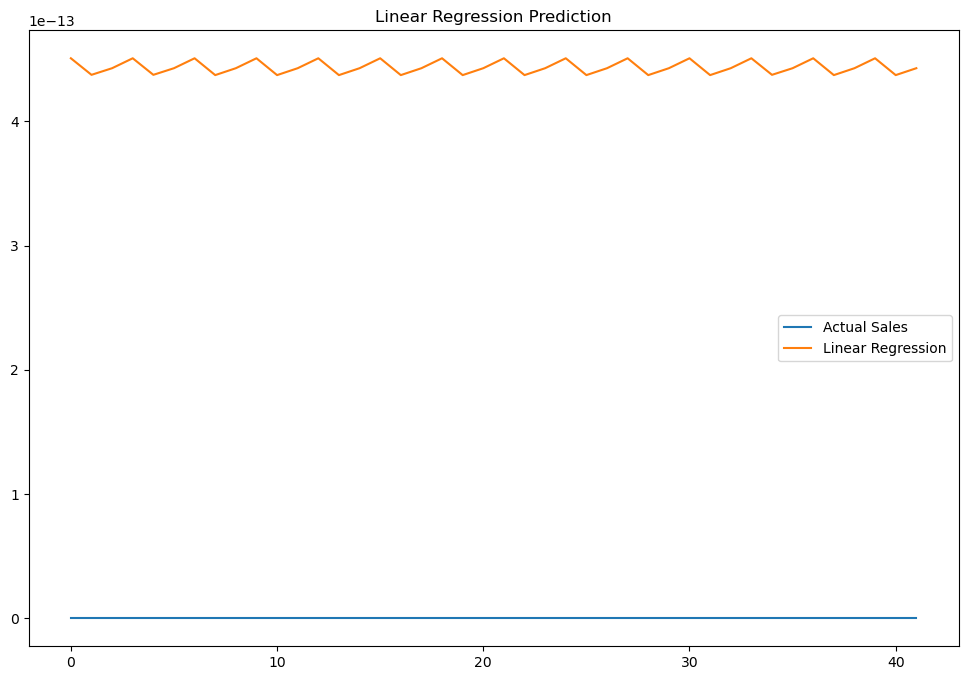

In [63]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label ='Actual Sales')
plt.plot(lin_pred, label='Linear Regression')
plt.legend(loc='best')
plt.title('Linear Regression Prediction')
plt.show()

In [64]:
mse = mean_squared_error(y_test, lin_pred )
#msle = mean_squared_log_error(y_test, lin_pred)
rmse = np.sqrt(mean_squared_error(y_test, lin_pred )).round(2)
#rmsle = np.sqrt(mean_squared_log_error(y_test, lin_pred)).round(2)

results = pd.DataFrame([['Linear', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE
0,Linear,1.968001e-25,0.0


### DecisionTreeRegressor

In [65]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_log = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_log.predict(X_test)

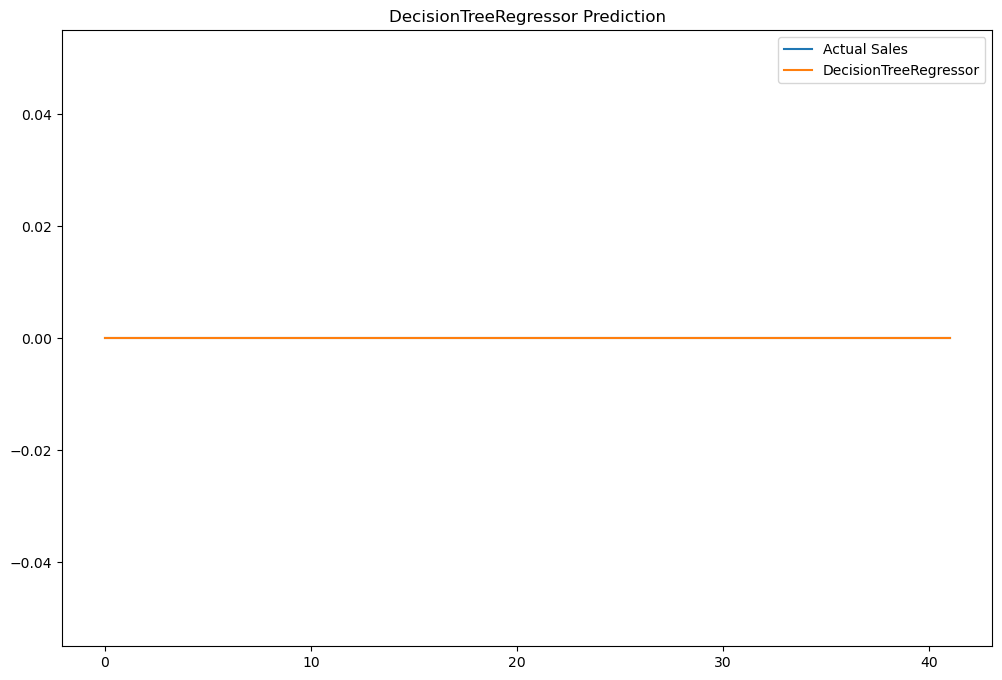

In [66]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [67]:
mse = mean_squared_error(y_test, tree_pred )
#msle = mean_squared_log_error(y_test, tree_pred)
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
#rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)

model_results = pd.DataFrame([['DecisionTree', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# model_results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE
0,Linear,1.968001e-25,0.0
1,DecisionTree,0.000000e+00,0.0


### RandomForestRegressor

In [68]:
from sklearn.ensemble import RandomForestRegressor
random = RandomForestRegressor()
model_randomForest = random.fit(X_train, y_train)

# Make prediction on X_test
rForest_pred = model_randomForest.predict(X_test)

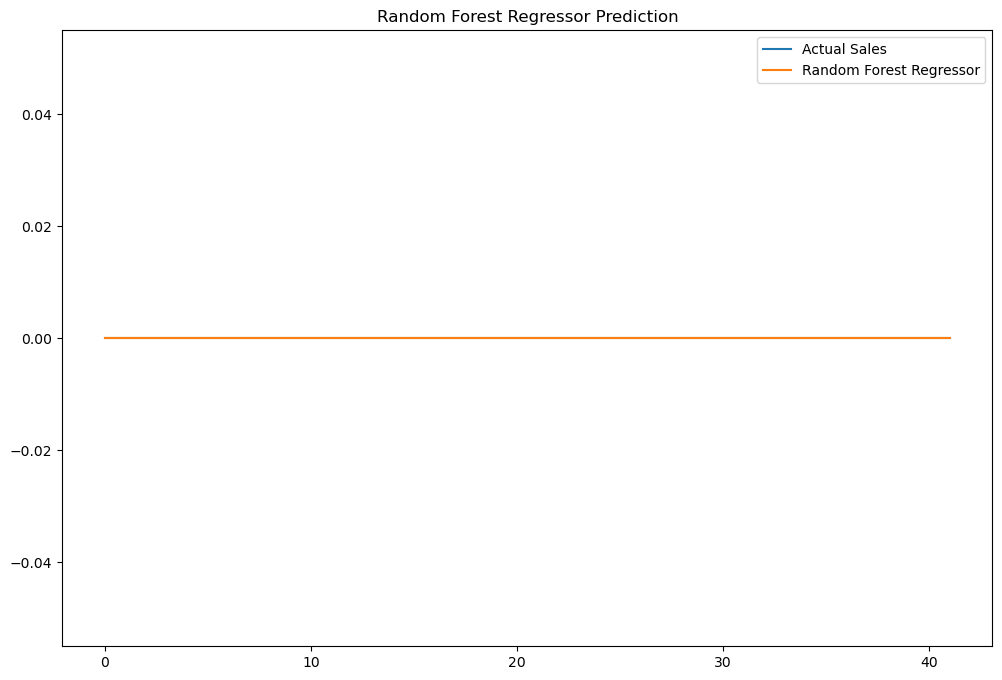

In [69]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label ='Actual Sales')
plt.plot(rForest_pred, label='Random Forest Regressor')
plt.legend(loc='best')
plt.title('Random Forest Regressor Prediction')
plt.show()

In [70]:
mse = mean_squared_error(y_test, rForest_pred )
#msle = mean_squared_log_error(y_test, rForest_pred)
rmse = np.sqrt(mean_squared_error(y_test, rForest_pred )).round(2)
#rmsle = np.sqrt(mean_squared_log_error(y_test, rForest_pred)).round(2)

model_results = pd.DataFrame([['rForest', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# model_results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE
0,Linear,1.968001e-25,0.0
1,DecisionTree,0.000000e+00,0.0
2,rForest,0.000000e+00,0.0


## Preparing our test data

In [71]:
test

,store_nbr,family,onpromotion
date,,,
2017-08-16,1,hardware,0
2017-08-16,1,home_and_kitchen,0
2017-08-16,1,home_and_kitchen,2
2017-08-16,1,groceries,20
2017-08-16,1,home_and_kitchen,0
...,...,...,...
2017-08-31,9,home_and_kitchen,1
2017-08-31,9,groceries,0
2017-08-31,9,groceries,1


for our test data, we merge just like for our train data

In [72]:
merged2_test=pd.merge(
    test.reset_index(), oil,
    how='outer', 
    on=['date']
    ).set_index('date')

merged3_test=pd.merge(
    merged2_test.reset_index(), holidays,
    how='outer', 
    on=['date']
    ).set_index('date')

missing values

In [73]:
merged3_test.isna().sum()

store_nbr       1368
family          1368
onpromotion     1368
oil_price       7318
type           27761
transferred    27761
dtype: int64

In [74]:
merged3_test['store_nbr'] = merged3_test['store_nbr'].interpolate(method='linear')
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
merged3_test['family'] = imputer.fit_transform(merged3_test[['family']])
merged3_test['onpromotion'] = merged3_test['onpromotion'].interpolate(method='linear')

#Fill missing holiday rows with normal days
def replacer(column, text):
    imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=text)
    merged3_test[column] = imputer.fit_transform(merged3_test[[column]])

replacer('type','Regular')
replacer('transferred',False)

# using linear interpolation
merged3_test['oil_price'] = merged3_test['oil_price'].interpolate(method='linear')
merged3_test['oil_price'] = merged3_test['oil_price'].bfill()

In [75]:
merged3_test.isna().sum()

store_nbr      0
family         0
onpromotion    0
oil_price      0
type           0
transferred    0
dtype: int64

features engineering

In [76]:
merged3_test['Year'] = merged3_test.index.year
merged3_test['Month'] = merged3_test.index.month
merged3_test['Quarter'] = merged3_test.index.quarter

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


cat_attribs=['family','type','transferred']
test_num=merged3_test.drop(['family','type','transferred'], axis=1)
num_attribs=list(test_num)


full_pipeline1 = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_attribs),
        ("num", numeric_transformer, num_attribs)
    ]
)
test_prepared=full_pipeline1.fit_transform(merged3_test)

convert test back to dataframe

In [78]:
test_prepared.shape

(29880, 17)

In [79]:
from pandas import DataFrame
test_preparedd = DataFrame(test_prepared, columns=['store_nbr', 'fam1','fam2','fam3', 'onpromotion', 'oil_price','type1','type2','type3','type4','type5','type6','type7','transferred', 'Year', 'Month', 'Quarter'])
test_preparedd

,store_nbr,fam1,fam2,fam3,onpromotion,oil_price,type1,type2,type3,type4,type5,type6,type7,transferred,Year,Month,Quarter
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.633098,-0.328109,-0.203844,0.182994,0.088694,0.091528
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.633098,-0.328109,-0.203844,0.182994,0.088694,0.091528
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.633098,-0.229377,-0.203844,0.182994,0.088694,0.091528
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.633098,0.659207,-0.203844,0.182994,0.088694,0.091528
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.633098,-0.328109,-0.203844,0.182994,0.088694,0.091528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29875,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.123810,-0.328109,-0.087977,0.182994,5.079591,3.948881
29876,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.123810,-0.328109,-0.087977,0.182994,5.079591,3.948881
29877,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.123810,-0.328109,-0.087977,0.182994,5.079591,3.948881
29878,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.123810,-0.328109,-0.087977,0.182994,5.079591,3.948881


### predicting sales in our test

In [80]:
rForest_pred_test = model_randomForest.predict(test_preparedd)

In [86]:
rForest_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [89]:
merged3_test['sales'] = rForest_pred_test
# Save sample submission
merged3_test[[ 'sales']].to_csv('submission.csv', index=False)